# Modify layers, maybe ConvLSTM

In [1]:
from __future__ import print_function, division


# from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, ConvLSTM2D, Conv3D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import tensorflow as tf

import matplotlib.pyplot as plt

import sys

import numpy as np

import os


In [14]:
class MIGAN():
    def __init__(self):
        self.frames = 3
        self.img_rows = 64 #28
        self.img_cols = 64 #28
        self.channels = 1 #1
        #train as image with 3 channels
        self.img_shape = (self.img_rows, self.img_cols, self.frames) 
        #train as sequence with 3 frames
        self.seq_shape = (self.frames, self.img_rows, self.img_cols, self.channels)


        # Cut and load the dataset to shape (90000,3,64,64,1)
        data = np.load("mnist_test_seq.npy")
        train_set = np.concatenate((data[0:6],data[6:12],data[12:18],data[1:7],data[7:13],data[13:19],data[2:8],data[8:14],data[14:20]),axis=1)
        self.Y_train = np.expand_dims(train_set[3:6].transpose(1,0,2,3), axis=4)
        self.X_train = np.expand_dims(train_set[0:3].transpose(1,0,2,3), axis=4)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()
#         self.generator.compile(loss=['mean_squared_error','mean_absolute_error'],loss_weights=[0.001, 0.999],optimizer=optimizer)

        # The generator takes ipt_imgs as input and generates gen_imgs
        ipt_imgs = Input(shape=(self.img_shape))
        gen_imgs = self.generator(ipt_imgs)
        

        # For the combined model we will only train the generator
        self.discriminator.trainable = False #True

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(gen_imgs)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(ipt_imgs, validity)
        self.combined.compile(loss=['mean_squared_error'binary_crossentropy'],loss_weights=[0.999,0.001],optimizer=optimizer)
#         self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        # Set checkpoints and save trained models
        self.checkpoint_dir = 'training_checkpoints2.2_G untrained'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "convlstm")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=optimizer,
                                         discriminator_optimizer=optimizer,
                                         generator=self.generator,
                                         discriminator=self.discriminator)

        
    def build_generator(self):

        model = Sequential()

        model_convlstm = Sequential(
            [
                Input(shape=self.seq_shape),  # Variable-length sequence of 64x64x1 frames
                ConvLSTM2D(filters=40, kernel_size=(3, 3), padding="same", return_sequences=True),
                BatchNormalization(),
                ConvLSTM2D(filters=40, kernel_size=(3, 3), padding="same", return_sequences=True),
                BatchNormalization(),
                ConvLSTM2D(filters=40, kernel_size=(3, 3), padding="same", return_sequences=True),
                BatchNormalization(),
                ConvLSTM2D(filters=40, kernel_size=(3, 3), padding="same", return_sequences=True),
                BatchNormalization(),
                Conv3D(filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"),
            ])

        model_convlstm.summary()
        


        ipt_imgs = Input(shape=(self.seq_shape))
        gen_imgs = model(ipt_imgs)

        return Model(ipt_imgs, gen_imgs)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.seq_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        
        model.summary()

        sam_imgs = Input(shape=self.seq_shape)
        validity = model(sam_imgs)

        return Model(sam_imgs, validity)

    def train(self, epochs, batch_size=32 , sample_interval=30):

        # Rescale -1 to 1
        Y_train = self.Y_train / 127.5 - 1.0
        X_train = self.X_train / 127.5 - 1.0
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, Y_train.shape[0], batch_size) 
            sam_imgs = Y_train[idx] #For Y_train
            ipt_imgs = X_train[idx]
            
            # Generate a batch of new images
            gen_imgs = self.generator.predict(ipt_imgs)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(sam_imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(ipt_imgs, valid)

            # Plot the progress every 20 epochs
            if (epoch + 1) % (3*sample_interval) == 0:
                print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # Save the models every 60 epochs
            if (epoch + 1) % (3*sample_interval) == 0:
                self.checkpoint.save(file_prefix = self.checkpoint_prefix)
                
            
            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.save_images(epoch)


    def save_images(self, epoch):

        # Select Y_train and X_train
        Y_train = self.Y_train
        X_train = self.X_train
        
        # Select a clip for ploting
        idx = np.random.randint(0, Y_train.shape[0], 32)
        ipt_imgs = X_train[idx][0].squeeze()
        gen_imgs = self.generator.predict(X_train[idx])[0].squeeze()
        sam_imgs = Y_train[idx][0].squeeze()

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        sam_imgs = 0.5 * sam_imgs + 0.5
        
        # Plot images
        fig = plt.figure()
        row1 = plt.subplot(3,3,1)
        plt.imshow(sam_imgs[0,:,:], cmap='gray')
        row1.title.set_text("Target sequence")
        plt.axis("off")
        plt.subplot(3,3,2)
        plt.imshow(sam_imgs[1,:,:], cmap='gray')
        plt.axis("off")
        plt.subplot(3,3,3)
        plt.imshow(sam_imgs[2,:,:], cmap='gray')
        plt.axis("off")

        row2 = plt.subplot(3,3,4)
        plt.imshow(ipt_imgs[0,:,:], cmap='gray')
        row2.title.set_text("Input sequence")
        plt.axis("off")
        plt.subplot(3,3,5)
        plt.imshow(ipt_imgs[1,:,:], cmap='gray')
        plt.axis("off")
        plt.subplot(3,3,6)
        plt.imshow(ipt_imgs[2,:,:], cmap='gray')
        plt.axis("off")
                
        row2 = plt.subplot(3,3,7)
        plt.imshow(gen_imgs[0,:,:], cmap='gray')
        row2.title.set_text("Generated sequence")
        plt.axis("off")
        plt.subplot(3,3,8)
        plt.imshow(gen_imgs[1,:,:], cmap='gray')
        plt.axis("off")
        plt.subplot(3,3,9)
        plt.imshow(gen_imgs[2,:,:], cmap='gray')
        plt.axis("off")
    
        crt_epoch = 'convlstm'+str(epoch)
        fig.savefig("generated_images2.2_G untrained/%s.png" % crt_epoch) #%d
        plt.close()


if __name__ == '__main__':
    gan = MIGAN()
    gan.checkpoint.restore(tf.train.latest_checkpoint(gan.checkpoint_dir))
#     gan.save_images("test")
    gan.train(epochs=5000, batch_size=32, sample_interval=20)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_9 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)               6291968   
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 257       
Total params: 6,423,553
Trainable params: 6,423,553
Non-trainable params: 0
___________________________________________

<function matplotlib.pyplot.show(*args, **kw)>

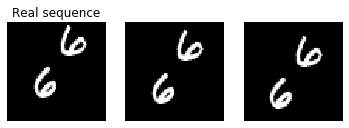

In [11]:
data = np.load("mnist_test_seq.npy")
train_set = np.concatenate((data[0:6],data[6:12],data[12:18],data[1:7],data[7:13],data[13:19],data[2:8],data[8:14],data[14:20]),axis=1)
Y_train = np.expand_dims(train_set[3:6].transpose(1,0,2,3), axis=4)

idx = np.random.randint(0, Y_train.shape[0], 10) 
sam_imgs = Y_train[idx][0].squeeze() #For Y_train




fig = plt.figure()
row1 = plt.subplot(2,3,1)
plt.imshow(sam_imgs[0,:,:], cmap='gray')
row1.title.set_text("Real sequence")
plt.axis("off")
plt.subplot(2,3,2)
plt.imshow(sam_imgs[1,:,:], cmap='gray')
plt.axis("off")
plt.subplot(2,3,3)
plt.imshow(sam_imgs[2,:,:], cmap='gray')
plt.axis("off")


plt.show

In [3]:
data = np.load("mnist_test_seq.npy")
print(data.shape)
train_set = np.concatenate((data[0:6],data[6:12],data[12:18],data[1:7],data[7:13],data[13:19],data[2:8],data[8:14],data[14:20]),axis=1)
print(train_set.shape)
Y_train = np.expand_dims(train_set[3:6].transpose(1,0,2,3), axis=4)
X_train = train_set[0:3].transpose(1,0,2,3)
print(Y_train.shape)




(20, 10000, 64, 64)
(6, 90000, 64, 64)
(90000, 3, 64, 64, 1)


In [2]:
frames = 3
img_rows = 64 #28
img_cols = 64 #28
channels = 1 #1
seq_shape = (frames, img_rows, img_cols, channels)
img_shape = (img_rows, img_cols, frames)

model = Sequential()

model.add(Flatten(input_shape=seq_shape))
model.add(Dense(512,input_shape=img_shape))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(momentum=0.8))
model.add(Dense(np.prod(seq_shape), activation='tanh'))
model.add(Reshape(img_shape))

model.summary()

model2 = Sequential()
model2.add(Dense(512, activation="relu", input_shape=img_shape))
# model2.add(Reshape((7, 7, 128)))
# model2.add(UpSampling2D())
model2.add(Conv2D(128, kernel_size=3, padding="same"))
model2.add(BatchNormalization(momentum=0.8))
model2.add(Activation("relu"))
# model2.add(UpSampling2D())
model2.add(Conv2D(64, kernel_size=3, padding="same"))
model2.add(BatchNormalization(momentum=0.8))
model2.add(Activation("relu"))
model2.add(Conv2D(channels, kernel_size=3, padding="same"))
model2.add(Activation("tanh"))


model2.summary()
        

model_convlstm = Sequential(
    [
        Input(shape=(seq_shape)),  # Variable-length sequence of 64x64x1 frames
        ConvLSTM2D(filters=40, kernel_size=(3, 3), padding="same", return_sequences=True),
        BatchNormalization(),
        ConvLSTM2D(filters=40, kernel_size=(3, 3), padding="same", return_sequences=True),
        BatchNormalization(),
        ConvLSTM2D(filters=40, kernel_size=(3, 3), padding="same", return_sequences=True),
        BatchNormalization(),
        ConvLSTM2D(filters=40, kernel_size=(3, 3), padding="same", return_sequences=True),
        BatchNormalization(),
        Conv3D(filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"),
    ])

model_convlstm.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               6291968   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1

In [55]:
frames = 3
img_rows = 64 #28
img_cols = 64 #28
channels = 1 #1
seq_shape = (frames, img_rows, img_cols, channels)
img_shape = (img_rows, img_cols, frames)

model = Sequential()

model.add(Flatten(input_shape=seq_shape))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 12288)             0         
_________________________________________________________________
dense_165 (Dense)            (None, 512)               6291968   
_________________________________________________________________
leaky_re_lu_126 (LeakyReLU)  (None, 512)               0         
_________________________________________________________________
dense_166 (Dense)            (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_127 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dense_167 (Dense)            (None, 1)                 257       
Total params: 6,423,553
Trainable params: 6,423,553
Non-trainable params: 0
___________________________________________

In [4]:
from __future__ import print_function, division


# from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, ConvLSTM2D, Conv3D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import tensorflow as tf

import matplotlib.pyplot as plt

import sys

import numpy as np

import os

frames = 3
img_rows = 64 #28
img_cols = 64 #28
channels = 1 #1
seq_shape = (frames, img_rows, img_cols, channels)
img_shape = (img_rows, img_cols, frames)
model = Sequential(
    [
        Input(shape=seq_shape),  # Variable-length sequence of 64x64x1 frames
        ConvLSTM2D(filters=40, kernel_size=(3, 3), padding="same", return_sequences=True),
        BatchNormalization(),
        ConvLSTM2D(filters=40, kernel_size=(3, 3), padding="same", return_sequences=True),
        BatchNormalization(),
        ConvLSTM2D(filters=40, kernel_size=(3, 3), padding="same", return_sequences=True),
        BatchNormalization(),
        ConvLSTM2D(filters=40, kernel_size=(3, 3), padding="same", return_sequences=True),
        BatchNormalization(),
        Conv3D(filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"),
    ])


# model.add(Flatten(input_shape=self.seq_shape))
# model.add(Dense(512))
# model.add(LeakyReLU(alpha=0.2))
# model.add(Dense(256))
# model.add(LeakyReLU(alpha=0.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_8 (ConvLSTM2D)  (None, 3, 64, 64, 40)     59200     
_________________________________________________________________
batch_normalization_8 (Batch (None, 3, 64, 64, 40)     160       
_________________________________________________________________
conv_lst_m2d_9 (ConvLSTM2D)  (None, 3, 64, 64, 40)     115360    
_________________________________________________________________
batch_normalization_9 (Batch (None, 3, 64, 64, 40)     160       
_________________________________________________________________
conv_lst_m2d_10 (ConvLSTM2D) (None, 3, 64, 64, 40)     115360    
_________________________________________________________________
batch_normalization_10 (Batc (None, 3, 64, 64, 40)     160       
_________________________________________________________________
conv_lst_m2d_11 (ConvLSTM2D) (None, 3, 64, 64, 40)    